# Description
### Context

Data has been collected from different hospitals, community clinics, maternal health cares through the IoT based risk monitoring system.

- Age: Age in years when a woman is pregnant.
- SystolicBP: Upper value of Blood Pressure in mmHg, another significant attribute during pregnancy.
- DiastolicBP: Lower value of Blood Pressure in mmHg, another significant attribute during pregnancy.
- BS: Blood glucose levels is in terms of a molar concentration, mmol/L.
- HeartRate: A normal resting heart rate in beats per minute.
- Risk Level: Predicted Risk Intensity Level during pregnancy considering the previous attribute.

In [5]:
!pip3 list | grep brot

brotlipy               0.7.0


In [6]:
sklearn.__version__

'1.1.0'

In [1]:
import warnings
warnings.filterwarnings("ignore")
import time
import math
import datetime
import pandas as pd
import numpy as np
import xlsxwriter

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split

from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from matplotlib import pyplot as plt

In [7]:
from sklearn.ensemble import RandomForestRegressor

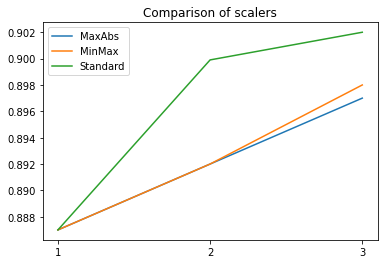

In [58]:
from matplotlib.ticker import FormatStrFormatter

maxabs = [0.887, 0.892, 0.897]
minmax = [0.887, 0.892, 0.898]
standard = [0.887, 0.8999, 0.902]
label = [1, 2, 3]


# fig, ax = plt.subplots()

# ax.plot(x, y)

# ax.set_xticklabels(x.astype(int))

plt.plot(label, maxabs, label='MaxAbs')
plt.plot(label, minmax, label='MinMax')
plt.plot(label, standard, label='Standard')
plt.xticks(label, rotation='horizontal')
plt.title('Comparison of scalers')
plt.legend()
plt.show()

In [2]:
df_train = pd.read_csv('datasets/trainCO.txt', header=None)
df_test = pd.read_csv('datasets/testCO.txt', header=None)
df_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,1292,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255,2.0
1,1402,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502,2.2
2,1376,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867,2.2
3,1197,4.7,750,89,1337,96,1393,949,11.2,59.2,0.7848,1.2
4,1185,3.6,690,62,1462,77,1333,733,11.3,56.8,0.7603,1.2


In [22]:
!ls

CO_results.xlsx                       code_for_errors.ipynb
CO_results_cascade_3_2_1_SVM_new.xlsx datasets
GTM.ipynb                             main.py
README.md                             requirements.txt
Training                              results_new
cascading.ipynb                       venv


# CO dataset

In [3]:
x_train = df_train.iloc[:,:-1]
y_train = df_train.iloc[:,-1]
x_test = df_test.iloc[:,:-1]
y_test = df_test.iloc[:,-1]

In [4]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((5000, 11), (1950, 11), (5000,), (1950,))

# Test

In [5]:
reg = make_pipeline(MaxAbsScaler(),
                        SGDRegressor(loss='epsilon_insensitive', alpha=0.0001, tol=1e-3))

reg.fit(x_train, y_train)

train_pred_y = reg.predict(x_train)
test_pred_y = reg.predict(x_test)

print(r2_score(test_pred_y, y_test))

0.8462072711048598


In [6]:
def calculate_errors(y_test, y_preds, info):
    """ return errors in tuple format"""
    mae = mean_absolute_error(y_test, y_preds)
    mse = mean_squared_error(y_test, y_preds)
    mape = mean_absolute_percentage_error(y_test, y_preds) 
    rmse = mean_squared_error(y_test, y_preds, squared=False)
    r2 = r2_score(y_test, y_preds)
    max_er = max_error(y_test, y_preds)
    med = median_absolute_error(y_test, y_preds)
    
    print(f'{info} errors')
    print('MAE:', mae)
    print('MSE:', mse)
    print('MAPE:', mape)
    print('RMSE:', rmse)
    print('R2 score:', r2)
    print('Max Error:', max_er)
    print('Median absolute error', med)

    print('-------')
    
    return mae, mse, mape, rmse, r2, max_er, med, 

In [7]:
def add_poly_features(poly, train_X, test_X):
    train_X = pd.DataFrame(poly.fit_transform(train_X))
    test_X  = pd.DataFrame(poly.fit_transform(test_X))
    return train_X, test_X

In [8]:
def evaluate_model(y_test, y_preds, time, polynom, info, loss, cascade, C, epsilon):
    '''Train model and display evaluation metrics.'''
    
    # Train the model, predict values and get metrics
    mae, mse, mape, rmse, r2, max_er, med = calculate_errors(y_test, y_preds, info)

    # Construct a dataframe to display metrics.
    display_df = pd.DataFrame([[C, epsilon, polynom, cascade, mae, mse, mape, rmse, r2, max_er, med, time, info]], columns=["C", "Epsilon", "Polynom", "Cascade", "mean_absolute_error", "mean_squarred_error", "mean_absolute_percentage_error", "Root_mean_squarred_error", "r2_score", 'max_error', 'median_absolute_error', 'Training ime', 'Info'])
    
    return display_df

In [16]:
%%time
def run_regression(X_train, y_train, X_test, y_test, info, loss, cascade, poly_degree = 2, C=1, epsilon=0.001):
    
    poly = PolynomialFeatures(poly_degree)
    X_train, X_test = add_poly_features(poly, X_train, X_test)
    
    reg = make_pipeline(StandardScaler(),
                        SVR(kernel='rbf', gamma='auto', C=C, epsilon=epsilon, max_iter=-1))
    #                    SGDRegressor(loss='epsilon_insensitive', alpha=0.0001, tol=1e-3))
    start = time.time()
    reg.fit(X_train, y_train)
    end = time.time()
    
    train_pred_y = reg.predict(X_train)
    test_pred_y = reg.predict(X_test)
    
    train_scores = evaluate_model(y_train, train_pred_y, end-start, poly_degree, info, loss, cascade, C, epsilon)
    train_results = train_scores

    test_scores = evaluate_model(y_test, test_pred_y, end-start, poly_degree, info, loss, cascade, C, epsilon)
    test_results = test_scores
    
    return reg, train_pred_y, test_pred_y, train_results, test_scores

CPU times: user 7 µs, sys: 4 µs, total: 11 µs
Wall time: 20 µs


In [17]:
def add_feature(X_train, X_test, train_pred_y, test_pred_y):
    X_train['pred'] = train_pred_y
    X_test['pred'] = test_pred_y
    return X_train, X_test

In [18]:
train_results_df = pd.DataFrame()
test_results_df = pd.DataFrame()

In [19]:
%%time
losses = ['squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']
loss = '-'
cs=[1, 0.5, 0.1]
epsilons=[0.0001, 0.001, 0.01]

i = 1
for c in cs:
    for eps in epsilons:
        # for i in range(1):
        print(i, ' Polynom calculated')
        reg, train_pred_y, test_pred_y, train_res, test_res = run_regression(x_train, y_train, x_test, y_test, 'Model without cascades', loss, '-', i, c, eps)
        print(train_res)
        train_results_df = train_results_df.append(train_res)
        test_results_df = test_results_df.append(test_res)

1  Polynom calculated
Model without cascades errors
MAE: 0.23588099690078587
MSE: 0.25257422305149624
MAPE: 0.1971336089806644
RMSE: 0.5025676303260053
R2 score: 0.8805862556846451
Max Error: 11.284936092173401
Median absolute error 0.12736805843252053
-------
Model without cascades errors
MAE: 0.2464236163166035
MSE: 0.21048699365303744
MAPE: 0.1788240484356073
RMSE: 0.45878861543529764
R2 score: 0.9034764594954424
Max Error: 8.563642266660956
Median absolute error 0.14309244305656854
-------
   C  Epsilon  Polynom Cascade  mean_absolute_error  mean_squarred_error  \
0  1   0.0001        1       -             0.235881             0.252574   

   mean_absolute_percentage_error  Root_mean_squarred_error  r2_score  \
0                        0.197134                  0.502568  0.880586   

   max_error  median_absolute_error  Training ime                    Info  
0  11.284936               0.127368      0.566467  Model without cascades  
1  Polynom calculated
Model without cascades erro

In [20]:
with pd.ExcelWriter('CO_01_11_standart_scaler_rbf.xlsx') as writer:  
    train_results_df.to_excel(writer, sheet_name='train', index=False)
    test_results_df.to_excel(writer, sheet_name='test', index=False)

# Divide dataset into parts

In [43]:
x_train

,0,1,2,3,4,5,6,7,8,9,10
0,1360,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,1272,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888
2,1136,3.3,672,62,1453,76,1333,730,10.7,60.0,0.7702
3,1094,2.3,609,45,1579,60,1276,620,10.7,59.7,0.7648
4,1066,1.1,512,16,1918,28,1182,422,11.0,56.2,0.7366
...,...,...,...,...,...,...,...,...,...,...,...
4995,844,5.5,786,130,969,61,1226,831,13.4,59.9,0.9173
4996,789,2.2,596,62,1145,48,1161,698,14.6,62.1,1.0236
4997,941,3.6,686,50,942,38,1406,549,22.8,64.0,1.7507
4998,1015,6.6,839,99,754,59,1473,970,21.4,69.3,1.7515


In [41]:
indexes = [0, 8, 9, 11]

X_train_1 = x_train.iloc[:, indexes[0]:indexes[1]]
X_train_2 = x_train.iloc[:, indexes[1]:indexes[2]]
X_train_3 = x_train.iloc[:, indexes[2]:indexes[3]]


X_test_1 = x_test.iloc[:, indexes[0]:indexes[1]]
X_test_2 = x_test.iloc[:, indexes[1]:indexes[2]]
X_test_3 = x_test.iloc[:, indexes[2]:indexes[3]]

In [42]:
%%time
train_res=pd.DataFrame()
test_res=pd.DataFrame()


# for i in range(2, 4):
for c in cs:
    for eps in epsilons:
        print('Part 1')            
        reg, train_pred_y, test_pred_y, train_r_df, test_r_df = run_regression(X_train_3, y_train, X_test_3, y_test, 'Cascade order: 3-1-2', loss, '1', 3, c, eps)
        X_train_1, X_test_1 = add_feature(X_train_1, X_test_1, train_pred_y, test_pred_y)
        train_res = train_res.append(train_r_df)
        test_res = test_res.append(test_r_df)


        print('Part 2')
        reg, train_pred_y, test_pred_y, train_r_df, test_r_df = run_regression(X_train_1, y_train, X_test_1, y_test, 'Cascade order: 3-1-2', loss, '2', 3, c, eps)
        X_train_2, X_test_2 = add_feature(X_train_2, X_test_2, train_pred_y, test_pred_y)
        train_res = train_res.append(train_r_df)
        test_res = test_res.append(test_r_df)


        print('Part 3')
        reg, train_pred_y, test_pred_y, train_r_df, test_r_df = run_regression(X_train_2, y_train, X_test_2, y_test, 'Cascade order: 3-1-2', loss, '3', 3, c, eps)
        train_res = train_res.append(train_r_df)
        test_res = test_res.append(test_r_df)


with pd.ExcelWriter('hp_search/CO_hp_search_cascade_3_1_2_25_10.xlsx') as writer:  
    train_res.to_excel(writer, sheet_name='train', index=False)
    test_res.to_excel(writer, sheet_name='test', index=False)
# reg.score(X_train_4, y_test)

Part 1
Cascade order: 3-1-2 errors
MAE: 1.0607988220462758
MSE: 2.19147490358884
MAPE: 0.7915900915758485
RMSE: 1.4803630985636058
R2 score: -0.03610028232104834
Max Error: 9.8374223222167
Median absolute error 0.817894045709179
-------
Cascade order: 3-1-2 errors
MAE: 1.0935401277178975
MSE: 2.301824071221038
MAPE: 0.7558107596793507
RMSE: 1.517176348095711
R2 score: -0.055553148994596624
Max Error: 9.879465890760248
Median absolute error 0.8435049901242692
-------
Part 2
Cascade order: 3-1-2 errors
MAE: 0.26100611262095774
MSE: 0.2656914497882501
MAPE: 0.21272375349165132
RMSE: 0.515452664934667
R2 score: 0.8743846047768646
Max Error: 11.363791781504267
Median absolute error 0.15053365853436107
-------
Cascade order: 3-1-2 errors
MAE: 0.26367961263915535
MSE: 0.21344587503111306
MAPE: 0.19094490678763013
RMSE: 0.46200202924999484
R2 score: 0.9021195979545549
Max Error: 8.51633676738292
Median absolute error 0.16551758965965746
-------
Part 3
Cascade order: 3-1-2 errors
MAE: 0.2582428

Cascade order: 3-1-2 errors
MAE: 1.062562279666364
MSE: 2.1979369671908593
MAPE: 0.7906359933351962
RMSE: 1.4825440860867711
R2 score: -0.03915546032535233
Max Error: 9.84107406957594
Median absolute error 0.8129975789756788
-------
Cascade order: 3-1-2 errors
MAE: 1.095826818906398
MSE: 2.312287944382515
MAPE: 0.7537633227494724
RMSE: 1.5206209075185422
R2 score: -0.06035159315215499
Max Error: 9.904411095563978
Median absolute error 0.8376039814392428
-------
Part 2
Cascade order: 3-1-2 errors
MAE: 0.26561687843144743
MSE: 0.2702546904575256
MAPE: 0.2156736989220195
RMSE: 0.5198602605100006
R2 score: 0.872227165082715
Max Error: 11.346462744487969
Median absolute error 0.1561315195932041
-------
Cascade order: 3-1-2 errors
MAE: 0.26771155789321055
MSE: 0.21933596176488546
MAPE: 0.19235031757534718
RMSE: 0.4683331738889372
R2 score: 0.8994185663347114
Max Error: 8.491127228121293
Median absolute error 0.16495415759678766
-------
Part 3
Cascade order: 3-1-2 errors
MAE: 0.26248832503360

# Зробити Грід Сьорч по параметрах